# Transformer + PPO Portfolio Optimization - Complete Demonstration

This notebook demonstrates the complete pipeline for the Transformer-based PPO reinforcement learning system for portfolio optimization.

## Overview

We implement a sophisticated portfolio optimization system that:
- Uses **Transformer architecture** to learn dynamic stock correlations
- Employs **PPO (Proximal Policy Optimization)** for robust policy learning
- Uses **Dirichlet distribution** to ensure valid portfolio weights
- Includes comprehensive backtesting with walk-forward validation

## Sections
1. Setup and Data Loading
2. Feature Engineering
3. Data Preprocessing
4. Model Architecture Overview
5. Training the PPO Agent
6. Backtesting
7. Performance Analysis
8. Visualization

In [88]:
!pip install gymnasium yfinance --quiet

## 1. Setup and Imports

In [1]:
# Standard imports

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../')

# Enable autoreload to pick up changes in source files
%load_ext autoreload
%autoreload 2

# Import our modules
from src.data.market_data import MarketDataLoader
from src.data.features import FeatureEngineering
from src.data.preprocessing import DataPreprocessor
from src.models.ppo_agent import PPOAgent
from src.environment.trading_env import TradingEnvironment
from src.training.trainer import PPOTrainer
from src.backtesting.engine import BacktestingEngine
from src.backtesting.metrics import PerformanceMetrics
from src.backtesting.visualization import BacktestVisualizer

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ Imports successful
PyTorch version: 2.9.1
Device: cpu


## 2. Load Configuration

In [2]:
# Load configuration
with open('../config/default_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Configure to use local CSV data from nifty_500_5min folder
config['data']['use_local_csv'] = True
config['data']['local_data_dir'] = '../nifty_500_5min'

# Date range for backtest (adjust based on your data availability)
config['data']['start_date'] = "2020-01-01"
config['data']['end_date'] = "2024-12-01"

# Number of stocks to use (can increase for more diversification)
config['data']['max_stocks'] = 10

# =============================================================================
# 🚀 AGGRESSIVE MODE CONFIGURATION
# =============================================================================
# Enable aggressive mode for concentrated, active portfolio weights
# Instead of converging to equal weights, the model will make active bets

config['model']['aggressive'] = True          # Enable aggressive weight mode
config['model']['temperature'] = 0.3          # Lower = more concentrated (0.3-0.5 recommended)
config['model']['max_weight'] = 0.30          # Allow larger single positions (30%)

config['training']['entropy_coef'] = 0.001    # Reduce entropy bonus (was 0.01)
config['training']['n_iterations'] = 150      # More training iterations

# Environment bonuses for concentrated, momentum-aligned portfolios
config['environment']['concentration_bonus'] = 0.005   # Reward concentrated portfolios
config['environment']['momentum_bonus'] = 0.003        # Reward momentum alignment

print("Configuration loaded:")
print(f"  Universe: {config['data']['universe']}")
print(f"  Date range: {config['data']['start_date']} to {config['data']['end_date']}")
print(f"  Data source: Local CSV files from nifty_500_5min")
print(f"  Max stocks: {config['data']['max_stocks']}")
print(f"  Stock embedding dim: {config['model']['stock_embedding_dim']}")
print(f"  Transformer layers: {config['model']['num_transformer_layers']}")
print(f"  Training iterations: {config['training']['n_iterations']}")

print("\n" + "="*60)
print("🚀 AGGRESSIVE MODE ENABLED")
print("="*60)
print(f"  Aggressive mode:       {config['model']['aggressive']}")
print(f"  Temperature:           {config['model']['temperature']}")
print(f"  Max single weight:     {config['model']['max_weight']*100:.0f}%")
print(f"  Entropy coefficient:   {config['training']['entropy_coef']}")
print(f"  Concentration bonus:   {config['environment']['concentration_bonus']}")
print(f"  Momentum bonus:        {config['environment']['momentum_bonus']}")

Configuration loaded:
  Universe: NIFTY50
  Date range: 2020-01-01 to 2024-12-01
  Data source: Local CSV files from nifty_500_5min
  Max stocks: 10
  Stock embedding dim: 64
  Transformer layers: 2
  Training iterations: 150

🚀 AGGRESSIVE MODE ENABLED
  Aggressive mode:       True
  Temperature:           0.3
  Max single weight:     30%
  Entropy coefficient:   0.001
  Concentration bonus:   0.005
  Momentum bonus:        0.003


## 3. Data Loading

We'll load stock price data and market index data. 

In [3]:
# =============================================================================
# BI-ANNUAL ROLLING STOCK SELECTION (Survivorship Bias Free)
# =============================================================================
# Key improvements:
# 1. Uses HISTORICAL NIFTY 50 composition (changes bi-annually)
# 2. Re-selects stocks every 6 months using only past data
# 3. Lookback period = 6 months (126 trading days) for selection metrics
# 4. No look-ahead bias - each period uses only data available at that time

# Force reload to pick up changes
import importlib
import src.data.stock_selector
importlib.reload(src.data.stock_selector)
from src.data.stock_selector import SmartStockSelector

# Initialize smart stock selector with BI-ANNUAL rebalancing
selector = SmartStockSelector(
    min_data_days=100,               # Reduced - we'll have data across periods
    max_volatility_percentile=80,    # Remove top 20% most volatile
    min_return_percentile=20,        # Remove bottom 20% performers  
    min_volume_percentile=20,        # Remove bottom 20% by liquidity
    lookback_days=126,               # 6-month lookback for metrics (half year)
    rebalance_frequency='biannual'   # Rebalance every 6 months (Jan & Jul)
)

print("=" * 80)
print("🔄 BI-ANNUAL ROLLING STOCK SELECTION")
print("   (Survivorship Bias Mitigation)")
print("=" * 80)
print(f"\n📋 Configuration:")
print(f"  • Rebalance frequency: Bi-annual (every 6 months)")
print(f"  • Selection lookback: 126 trading days (~6 months)")
print(f"  • NIFTY 50 composition: Updated bi-annually from historical data")
print(f"  • Universe updates: H1 uses prior year composition, H2 uses current year")
print(f"  • Target stocks per period: {config['data']['max_stocks']}")

# Load data and perform rolling selection
print("\n⏳ Loading and processing data (this may take a few minutes)...")
stock_data, period_selections, selection_report = selector.load_and_filter_stocks_rolling(
    data_dir=config['data']['local_data_dir'],
    start_date=config['data']['start_date'],
    end_date=config['data']['end_date'],
    target_count=config['data']['max_stocks']
)

# Get list of all unique stocks across all periods
all_stocks = selection_report['all_selected_stocks']

print(f"\n" + "=" * 80)
print("📊 ROLLING SELECTION SUMMARY")
print("=" * 80)
print(f"\n  Total rebalancing periods: {len(period_selections)}")
print(f"  Total unique stocks selected: {len(all_stocks)}")

# Show selection for each period
print(f"\n📅 Stocks Selected by Period:")
for period_date, stocks_list in period_selections.items():
    nifty_composition = selector.get_nifty50_for_date(period_date)
    print(f"\n  {period_date.strftime('%Y-%m-%d')} (NIFTY 50 as of {period_date.year}):")
    print(f"    Selected: {len(stocks_list)} stocks")
    print(f"    Stocks: {stocks_list[:10]}{'...' if len(stocks_list) > 10 else ''}")

# Store for later use in backtesting
stocks = all_stocks  # All unique stocks across periods

# Initialize MarketDataLoader for NIFTY index loading
loader = MarketDataLoader()

# Load NIFTY index
print("\n" + "=" * 80)
print("📊 Loading NIFTY Index Data")
print("=" * 80)
nifty_data = loader.load_index_from_local(
    data_dir=config['data']['local_data_dir'],
    start_date=config['data']['start_date'],
    end_date=config['data']['end_date'],
    resample_to_daily=True
)

# For local data, we don't have USD/INR, Crude, Bond data
usdinr_data = None
crude_data = None
bond_data = None

# Get sector mapping
sector_mapping = loader.get_sector_mapping()

print(f"\n✓ Data loaded successfully")
print(f"  Total unique stocks: {len(stocks)}")
print(f"  Date range: {stock_data['Date'].min().date()} to {stock_data['Date'].max().date()}")
print(f"  Total observations: {len(stock_data):,}")
print(f"  Trading days: {stock_data['Date'].nunique()}")

# Store period selections for use in backtesting
# This tells us which stocks were active in each period
print(f"\n📝 Period Selection Summary (for backtesting):")
for i, (period_date, stocks_list) in enumerate(period_selections.items()):
    end_date_str = list(period_selections.keys())[i+1].strftime('%Y-%m-%d') if i < len(period_selections)-1 else config['data']['end_date']
    print(f"   Period {i+1}: {period_date.strftime('%Y-%m-%d')} to {end_date_str}: {len(stocks_list)} stocks")

# Display sample data
print(f"\n📋 Sample Data:")
stock_data.head(10)

🔄 BI-ANNUAL ROLLING STOCK SELECTION
   (Survivorship Bias Mitigation)

📋 Configuration:
  • Rebalance frequency: Bi-annual (every 6 months)
  • Selection lookback: 126 trading days (~6 months)
  • NIFTY 50 composition: Updated bi-annually from historical data
  • Universe updates: H1 uses prior year composition, H2 uses current year
  • Target stocks per period: 10

⏳ Loading and processing data (this may take a few minutes)...
🔄 ROLLING STOCK SELECTION (Bi-Annual)
📂 Loading all stock data from ../nifty_500_5min...
   Loaded 50 stocks...
   Loaded 100 stocks...
   Loaded 150 stocks...
   Loaded 200 stocks...
   Loaded 250 stocks...
   Loaded 300 stocks...
   Loaded 350 stocks...
   Loaded 400 stocks...
   Loaded 450 stocks...
   ✓ Loaded 485 stocks total

📅 Rebalancing dates (biannual):
   • 2020-01-01
   • 2020-07-01
   • 2021-01-01
   • 2021-07-01
   • 2022-01-01
   • 2022-07-01
   • 2023-01-01
   • 2023-07-01
   • 2024-01-01
   • 2024-07-01

🔍 Selecting stocks for each period...

--

,Date,Open,High,Low,Close,Volume,Stock
0,2020-01-01,368.00,379.15,366.00,377.45,11360102,ADANIPORTS
1,2020-01-01,1790.20,1802.55,1783.20,1784.90,395756,ASIANPAINT
2,2020-01-01,754.90,759.95,747.20,748.75,4903926,AXISBANK
3,2020-01-01,3104.50,3114.50,3065.50,3073.00,319098,BAJAJ-AUTO
4,2020-01-01,942.00,943.25,935.20,937.15,633950,BAJAJFINSV
5,2020-01-01,424.00,425.00,422.00,423.00,4062410,BAJFINANCE
6,2020-01-01,447.65,451.95,441.45,445.35,5150097,BHARTIARTL
7,2020-01-01,235.50,236.40,233.80,235.10,4756592,BPCL
8,2020-01-01,3044.70,3053.00,3027.40,3037.90,110402,BRITANNIA
9,2020-01-01,481.00,481.00,474.45,476.40,1314043,CIPLA


## 4. Feature Engineering

We compute:
- **Stock features**: Returns, momentum, volatility, technical indicators
- **Market features**: NIFTY returns, volatility, macro indicators

In [164]:
# Force reimport to pick up code changes
import importlib
import src.data.features
importlib.reload(src.data.features)
from src.data.features import FeatureEngineering

# Initialize feature engineering
fe = FeatureEngineering(lookback_window=config['data']['lookback_window'])

# Compute stock features
print("Computing stock features...")
stock_features = fe.compute_stock_features(stock_data)

# Add sector-relative features
print("Computing sector-relative features...")
stock_features = fe.compute_sector_relative_features(stock_features, sector_mapping)

# Compute market features with available market data
# Note: usdinr_data, crude_data, bond_data are None when using local CSV data
print("Computing market features...")
market_features = fe.compute_market_features(
    nifty_data,
    usdinr_prices=usdinr_data,
    crude_prices=crude_data,
    bond_yields=bond_data
)

# Get feature columns (these now reflect what was actually computed)
stock_feature_cols = fe.get_feature_columns()
market_feature_cols = fe.get_market_feature_columns()

print(f"\n✓ Features engineered")
print(f"  Stock features: {len(stock_feature_cols)}")
print(f"  Market features: {len(market_feature_cols)}")
print(f"\nStock features: {stock_feature_cols}")
print(f"\nMarket features: {market_feature_cols}")

# Display sample - ONLY show rows with valid (non-NaN) feature values
# The first ~20 rows have NaN due to lookback window requirements
feature_cols_to_show = ['Date', 'Stock', 'Returns', 'Momentum_10', 'Volatility_20', 'RSI_14']
valid_features = stock_features[feature_cols_to_show].dropna()

print(f"\n📋 Sample Features (first {min(10, len(valid_features))} valid rows after lookback window):")
print(f"   Note: First ~20 rows are NaN due to lookback calculations")
valid_features.head(10)

Computing stock features...
Computing sector-relative features...
Computing sector-relative features...
Computing market features...

✓ Features engineered
  Stock features: 16
  Market features: 4

Stock features: ['Returns', 'LogReturns', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'HighLow_Range', 'OpenClose_Range', 'Price_to_SMA5', 'Price_to_SMA10', 'Price_to_SMA20', 'Volume_Change', 'Volume_Ratio', 'RSI_14']

Market features: ['NIFTY_Return', 'NIFTY_Volatility', 'NIFTY_Momentum_5', 'NIFTY_Momentum_10']

📋 Sample Features (first 10 valid rows after lookback window):
   Note: First ~20 rows are NaN due to lookback calculations
Computing market features...

✓ Features engineered
  Stock features: 16
  Market features: 4

Stock features: ['Returns', 'LogReturns', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'HighLow_Range', 'OpenClose_Range', 'Price_to_SMA5', 'Price_to_SMA10', 'Price_to_

,Date,Stock,Returns,Momentum_10,Volatility_20,RSI_14
20,2020-01-29,ADANIPORTS,0.023411,-0.020612,0.010784,38.768116
21,2020-01-30,ADANIPORTS,-0.011765,-0.033248,0.010695,35.352423
22,2020-01-31,ADANIPORTS,-0.019841,-0.040777,0.011536,31.074540
23,2020-02-01,ADANIPORTS,-0.021997,-0.046071,0.012393,27.319149
24,2020-02-03,ADANIPORTS,0.018352,-0.028180,0.012875,33.124511
25,2020-02-04,ADANIPORTS,-0.002710,-0.041667,0.012820,32.142857
26,2020-02-05,ADANIPORTS,0.000000,-0.044156,0.012051,34.702431
27,2020-02-06,ADANIPORTS,0.005707,-0.038077,0.012205,41.192412
28,2020-02-07,ADANIPORTS,-0.003513,-0.031258,0.012206,40.353982
29,2020-02-10,ADANIPORTS,0.000542,-0.012709,0.012228,35.687023


## 5. Data Preprocessing

Normalize features and create time-aligned sequences for model training.

In [165]:
# =============================================================================
# BIAS-FREE PREPROCESSING: Fit scaler ONLY on training data
# =============================================================================

# Get unique stocks (sorted for consistency)
stocks = sorted(stock_features['Stock'].unique())
num_stocks = len(stocks)

print(f"Number of stocks: {num_stocks}")
print(f"Stocks: {stocks[:10]}...")

# Normalize dates - handle timezone-aware dates
def normalize_dates(df, date_col='Date'):
    """Normalize dates by removing timezone and keeping only date part"""
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    # Remove timezone if present
    if df[date_col].dt.tz is not None:
        df[date_col] = df[date_col].dt.tz_localize(None)
    # Normalize to midnight
    df[date_col] = df[date_col].dt.normalize()
    return df

stock_features = normalize_dates(stock_features)
market_features = normalize_dates(market_features)

# Get common dates where we have both stock and market data
stock_dates = set(stock_features['Date'].unique())
market_dates = set(market_features['Date'].unique())
common_dates = sorted(stock_dates & market_dates)

print(f"\nDate alignment:")
print(f"  Stock data dates: {len(stock_dates)}")
print(f"  Market data dates: {len(market_dates)}")
print(f"  Common dates: {len(common_dates)}")

if len(common_dates) == 0:
    print("\n⚠️ DEBUG: Sample dates from each dataset")
    print(f"  Stock dates sample: {sorted(list(stock_dates))[:5]}")
    print(f"  Market dates sample: {sorted(list(market_dates))[:5]}")
    raise ValueError("No common dates found!")

# =============================================================================
# KEY FIX: Determine train/test split BEFORE fitting scaler
# =============================================================================
train_ratio = config['data']['train_ratio']
n_total = len(common_dates)
n_train = int(n_total * train_ratio)

train_cutoff_date = common_dates[n_train - 1]  # Last date in training set

print(f"\n🔧 BIAS FIX: Fitting scaler ONLY on training data")
print(f"   Train cutoff date: {train_cutoff_date.date()}")
print(f"   Training dates: {n_train}")
print(f"   Test dates: {n_total - n_train}")

# =============================================================================
# Filter data to ONLY include training period for scaler fitting
# =============================================================================
train_stock_features = stock_features[stock_features['Date'] <= train_cutoff_date].copy()
train_market_features = market_features[market_features['Date'] <= train_cutoff_date].copy()

print(f"\n   Training stock observations: {len(train_stock_features):,}")
print(f"   Training market observations: {len(train_market_features):,}")

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Prepare data for fitting - drop rows with NaN in feature columns (TRAINING ONLY)
valid_train_stock = train_stock_features.dropna(subset=stock_feature_cols)
valid_train_market = train_market_features.dropna(subset=market_feature_cols)

print(f"\n   Valid training stock obs: {len(valid_train_stock):,}")
print(f"   Valid training market obs: {len(valid_train_market):,}")

# FIT SCALER ON TRAINING DATA ONLY ✅
print("\n✅ Fitting preprocessor on TRAINING data only (no information leakage)...")
preprocessor.fit(
    valid_train_stock,
    valid_train_market,
    stock_feature_cols,
    market_feature_cols
)

print(f"   Scaler fitted on dates: {valid_train_stock['Date'].min().date()} to {valid_train_stock['Date'].max().date()}")

# =============================================================================
# Now create sequences for ALL data (but scaler was fit only on training)
# =============================================================================
print("\nCreating sequences (using scaler fitted on training data)...")
stock_sequences, market_sequences, valid_dates = preprocessor.create_sequences(
    stock_features,
    market_features,
    pd.DatetimeIndex(common_dates),
    stocks
)

# Get aligned returns
returns = preprocessor.align_returns(stock_features, valid_dates, stocks)

print(f"\n✅ Sequences created (BIAS-FREE)")
print(f"  Stock sequences shape: {stock_sequences.shape}")
print(f"  Market sequences shape: {market_sequences.shape}")
print(f"  Returns shape: {returns.shape}")
print(f"  Valid dates: {len(valid_dates)}")
print(f"  Date range: {valid_dates[0].date()} to {valid_dates[-1].date()}")

Number of stocks: 37
Stocks: ['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA']...

Date alignment:
  Stock data dates: 1211
  Market data dates: 1211
  Common dates: 1211

🔧 BIAS FIX: Fitting scaler ONLY on training data
   Train cutoff date: 2023-06-07
   Training dates: 847
   Test dates: 364

   Training stock observations: 31,339
   Training market observations: 847

   Valid training stock obs: 30,599
   Valid training market obs: 827

✅ Fitting preprocessor on TRAINING data only (no information leakage)...
   Scaler fitted on dates: 2020-01-29 to 2023-06-07

Creating sequences (using scaler fitted on training data)...

✅ Sequences created (BIAS-FREE)
  Stock sequences shape: (1211, 37, 16)
  Market sequences shape: (1211, 4)
  Returns shape: (1211, 37)
  Valid dates: 1211
  Date range: 2020-01-01 to 2024-11-29

✅ Sequences created (BIAS-FREE)
  Stock sequences shape: (1211, 37, 16)
  Market sequences sha

## 6. Train-Test Split

In [166]:
# Split data chronologically
train_ratio = config['data']['train_ratio']

(
    train_stock, train_market, train_returns, train_dates,
    test_stock, test_market, test_returns, test_dates
) = preprocessor.split_train_test(
    stock_sequences, market_sequences, returns, valid_dates, train_ratio
)

print(f"Train period: {train_dates[0]} to {train_dates[-1]}")
print(f"  Train samples: {len(train_dates)}")
print(f"\nTest period: {test_dates[0]} to {test_dates[-1]}")
print(f"  Test samples: {len(test_dates)}")

Train period: 2020-01-01 00:00:00 to 2023-06-07 00:00:00
  Train samples: 847

Test period: 2023-06-08 00:00:00 to 2024-11-29 00:00:00
  Test samples: 364


## 7. Model Architecture

### Components:
1. **Stock Feature Encoder** (Transformer): Learns correlations between stocks
2. **Market Context Encoder** (MLP): Processes market-level features
3. **Policy Network**: Generates portfolio weights via Dirichlet distribution
4. **Value Network**: Estimates state value for PPO training

In [ ]:
# Model hyperparameters
num_stock_features = len(stock_feature_cols)
num_market_features = len(market_feature_cols)

# Initialize PPO Agent with AGGRESSIVE MODE
print("Initializing PPO Agent with AGGRESSIVE MODE...")
agent = PPOAgent(
    num_stock_features=num_stock_features,
    num_market_features=num_market_features,
    num_stocks=num_stocks,
    stock_embedding_dim=config['model']['stock_embedding_dim'],
    market_embedding_dim=config['model']['market_embedding_dim'],
    num_transformer_heads=config['model']['num_transformer_heads'],
    num_transformer_layers=config['model']['num_transformer_layers'],
    policy_hidden_dim=config['model']['policy_hidden_dim'],
    value_hidden_dim=config['model']['value_hidden_dim'],
    dropout=config['model']['dropout'],
    max_weight=config['model']['max_weight'],
    device=config['device'],
    # AGGRESSIVE MODE PARAMETERS
    aggressive=config['model'].get('aggressive', False),
    temperature=config['model'].get('temperature', 1.0)
)

# Count parameters
total_params = sum(p.numel() for p in agent.parameters())
trainable_params = sum(p.numel() for p in agent.parameters() if p.requires_grad)

print(f"\n✓ Model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

if config['model'].get('aggressive', False):
    print(f"\n🚀 AGGRESSIVE MODE ACTIVE:")
    print(f"  • Temperature: {config['model'].get('temperature', 1.0)}")
    print(f"  • Max weight: {config['model']['max_weight']*100:.0f}%")
    print(f"  • This will produce CONCENTRATED, NON-EQUAL weights")

print(f"\nModel architecture:")
print(agent)

Initializing PPO Agent...

✓ Model initialized
  Total parameters: 166,243
  Trainable parameters: 166,243

Model architecture:
PPOAgent(
  (stock_encoder): StockFeatureEncoder(
    (feature_projection): Linear(in_features=16, out_features=64, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

## 8. Create Trading Environment

In [ ]:
# Create training environment with AGGRESSIVE MODE bonuses
print("Creating trading environment with AGGRESSIVE MODE...")
env = TradingEnvironment(
    stock_sequences=train_stock,
    market_sequences=train_market,
    returns=train_returns,
    dates=train_dates,
    transaction_cost=config['environment']['transaction_cost'],
    turnover_penalty=config['environment'].get('turnover_penalty', 0.0005),
    initial_cash=config['environment']['initial_cash'],
    normalize_rewards=config['training']['normalize_rewards'],
    random_start=config['training']['random_start'],
    episode_length=config['training']['episode_length'],
    # AGGRESSIVE MODE BONUSES
    concentration_bonus=config['environment'].get('concentration_bonus', 0.0),
    momentum_bonus=config['environment'].get('momentum_bonus', 0.0)
)

print(f"\n✓ Environment created")
print(f"  Action space: {env.action_space}")
print(f"  Observation space: {env.observation_space}")
print(f"  Episode length: {config['training']['episode_length']} days")

if config['environment'].get('concentration_bonus', 0) > 0 or config['environment'].get('momentum_bonus', 0) > 0:
    print(f"\n🚀 AGGRESSIVE MODE BONUSES:")
    print(f"  • Concentration bonus: {config['environment'].get('concentration_bonus', 0)}")
    print(f"  • Momentum bonus: {config['environment'].get('momentum_bonus', 0)}")
    print(f"  • These reward concentrated, momentum-aligned portfolios")

Creating trading environment...

✓ Environment created
  Action space: Box(0.0, 1.0, (37,), float32)
  Observation space: Dict('market_features': Box(-inf, inf, (4,), float32), 'previous_weights': Box(0.0, 1.0, (37,), float32), 'stock_features': Box(-inf, inf, (37, 16), float32))
  Episode length: 252 days


## 9. Train PPO Agent

Train using Proximal Policy Optimization with:
- Clipped surrogate objective
- Value function loss
- Entropy bonus for exploration

In [ ]:
# Initialize trainer with AGGRESSIVE settings
print("Initializing PPO Trainer...")
print(f"  Entropy coefficient: {config['training']['entropy_coef']} (reduced for concentrated weights)")

trainer = PPOTrainer(
    agent=agent,
    env=env,
    learning_rate=config['training']['learning_rate'],
    gamma=config['training']['gamma'],
    gae_lambda=config['training']['gae_lambda'],
    clip_epsilon=config['training']['clip_epsilon'],
    value_coef=config['training']['value_coef'],
    entropy_coef=config['training']['entropy_coef'],  # Reduced in aggressive mode
    max_grad_norm=config['training']['max_grad_norm'],
    n_epochs=config['training']['n_epochs'],
    batch_size=config['training']['batch_size'],
    buffer_size=config['training']['buffer_size'],
    device=config['device']
)

print("\n" + "="*60)
print("Starting Training (AGGRESSIVE MODE)")
print("="*60)
print(f"  Training iterations: {config['training']['n_iterations']}")
print(f"  Steps per iteration: {config['training']['n_steps_per_iteration']}")

# Train the agent
training_stats = trainer.train(
    n_iterations=config['training']['n_iterations'],
    n_steps_per_iteration=config['training']['n_steps_per_iteration']
)

print("\n" + "="*60)
print("✓ Training completed")
print("="*60)

Initializing PPO Trainer...

Starting Training
Starting PPO training for 100 iterations...


 10%|█         | 10/100 [00:48<07:50,  5.23s/it]


Iteration 10/100
  Avg Episode Reward: 1.2584
  Avg Episode Length: 252.0
  Policy Loss: -0.0068
  Value Loss: 0.7369


 20%|██        | 20/100 [01:34<05:44,  4.31s/it]


Iteration 20/100
  Avg Episode Reward: -2.7603
  Avg Episode Length: 252.0
  Policy Loss: -0.0210
  Value Loss: 0.7881


 30%|███       | 30/100 [02:17<04:56,  4.23s/it]


Iteration 30/100
  Avg Episode Reward: -3.8297
  Avg Episode Length: 252.0
  Policy Loss: -0.0047
  Value Loss: 0.5847


 40%|████      | 40/100 [03:01<04:33,  4.56s/it]


Iteration 40/100
  Avg Episode Reward: 1.8593
  Avg Episode Length: 252.0
  Policy Loss: -0.0288
  Value Loss: 0.4070


 50%|█████     | 50/100 [03:45<03:37,  4.35s/it]


Iteration 50/100
  Avg Episode Reward: 4.2579
  Avg Episode Length: 252.0
  Policy Loss: -0.0168
  Value Loss: 0.7862


 60%|██████    | 60/100 [04:29<02:56,  4.41s/it]


Iteration 60/100
  Avg Episode Reward: -0.1271
  Avg Episode Length: 252.0
  Policy Loss: -0.0093
  Value Loss: 0.5349


 70%|███████   | 70/100 [05:14<02:13,  4.45s/it]


Iteration 70/100
  Avg Episode Reward: -4.2933
  Avg Episode Length: 252.0
  Policy Loss: -0.0065
  Value Loss: 0.7660


 80%|████████  | 80/100 [05:58<01:29,  4.45s/it]


Iteration 80/100
  Avg Episode Reward: -4.0287
  Avg Episode Length: 252.0
  Policy Loss: -0.0077
  Value Loss: 2.3544


 90%|█████████ | 90/100 [06:42<00:45,  4.57s/it]


Iteration 90/100
  Avg Episode Reward: 3.9614
  Avg Episode Length: 252.0
  Policy Loss: -0.0089
  Value Loss: 0.7218


100%|██████████| 100/100 [07:27<00:00,  4.48s/it]


Iteration 100/100
  Avg Episode Reward: 3.2360
  Avg Episode Length: 252.0
  Policy Loss: -0.0005
  Value Loss: 0.6393

✓ Training completed


## 10. Training Analysis

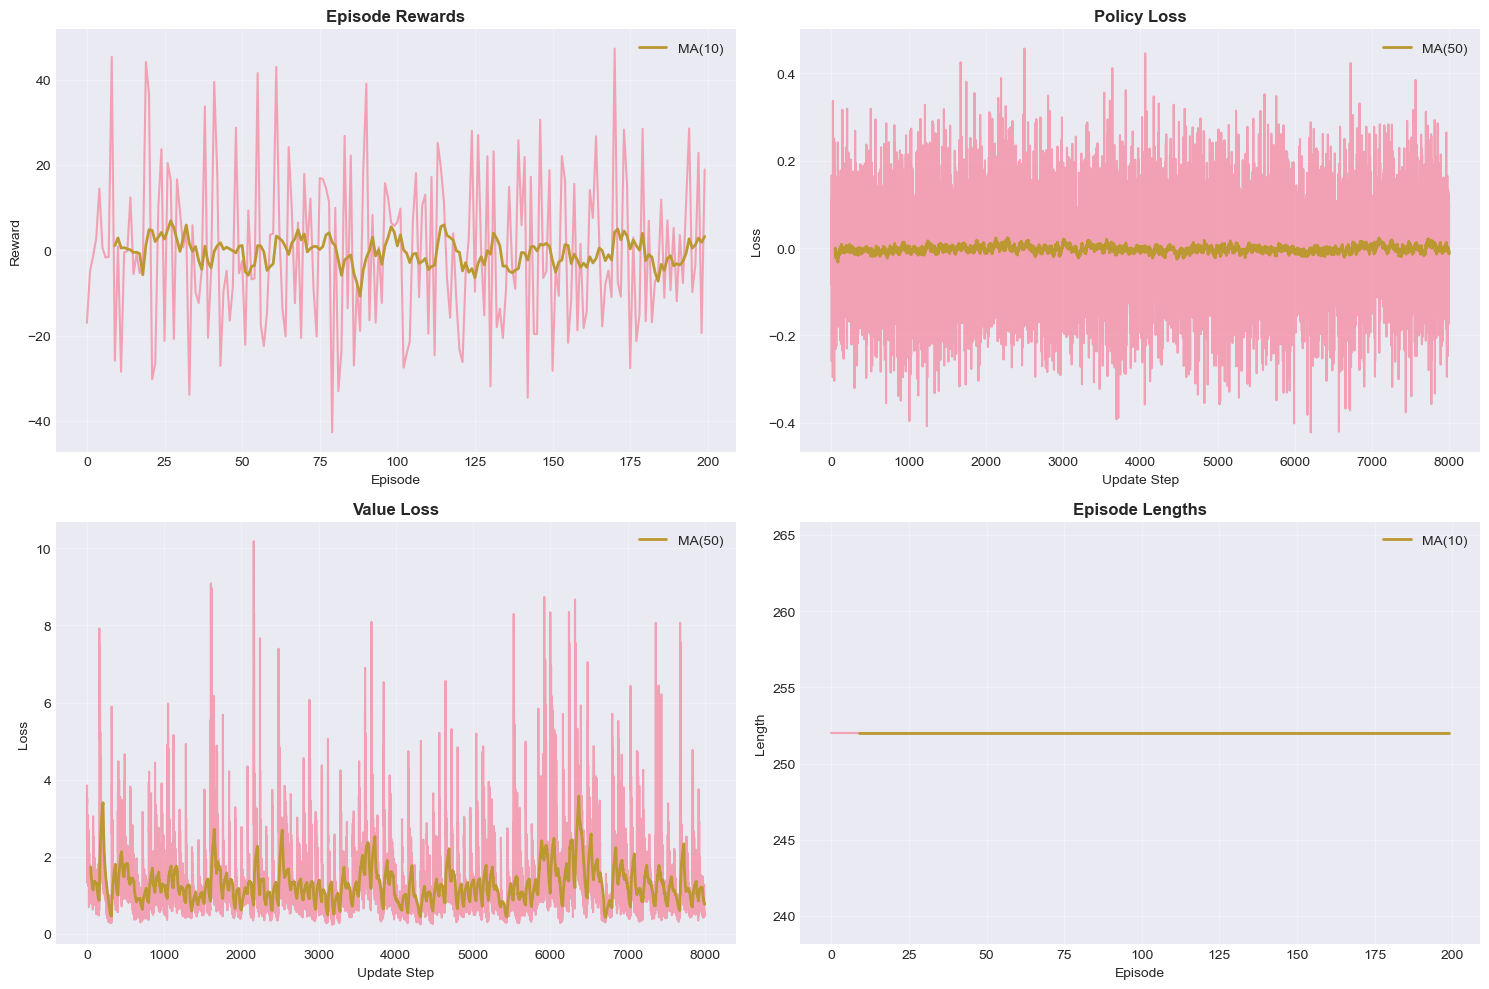

Training Statistics:
  Total episodes: 200
  Average episode reward: -0.2630
  Final 10 episodes avg reward: 3.2360
  Average episode length: 252.0


In [169]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(training_stats['episode_rewards'], alpha=0.6)
axes[0, 0].plot(pd.Series(training_stats['episode_rewards']).rolling(10).mean(), 
                linewidth=2, label='MA(10)')
axes[0, 0].set_title('Episode Rewards', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Policy loss
axes[0, 1].plot(training_stats['policy_losses'], alpha=0.6)
axes[0, 1].plot(pd.Series(training_stats['policy_losses']).rolling(50).mean(),
                linewidth=2, label='MA(50)')
axes[0, 1].set_title('Policy Loss', fontweight='bold')
axes[0, 1].set_xlabel('Update Step')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Value loss
axes[1, 0].plot(training_stats['value_losses'], alpha=0.6)
axes[1, 0].plot(pd.Series(training_stats['value_losses']).rolling(50).mean(),
                linewidth=2, label='MA(50)')
axes[1, 0].set_title('Value Loss', fontweight='bold')
axes[1, 0].set_xlabel('Update Step')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Episode lengths
axes[1, 1].plot(training_stats['episode_lengths'], alpha=0.6)
axes[1, 1].plot(pd.Series(training_stats['episode_lengths']).rolling(10).mean(),
                linewidth=2, label='MA(10)')
axes[1, 1].set_title('Episode Lengths', fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Length')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Training Statistics:")
print(f"  Total episodes: {len(training_stats['episode_rewards'])}")
print(f"  Average episode reward: {np.mean(training_stats['episode_rewards']):.4f}")
print(f"  Final 10 episodes avg reward: {np.mean(training_stats['episode_rewards'][-10:]):.4f}")
print(f"  Average episode length: {np.mean(training_stats['episode_lengths']):.1f}")

## 11. Backtesting

Test the trained agent on out-of-sample data.

In [170]:
# Initialize backtesting engine
print("Initializing backtesting engine...")
backtester = BacktestingEngine(
    agent=agent,
    transaction_cost=config['environment']['transaction_cost'],
    initial_cash=config['environment']['initial_cash']
)

print("\nRunning backtest on test data...")
backtest_results = backtester.run_backtest(
    stock_sequences=test_stock,
    market_sequences=test_market,
    returns=test_returns,
    dates=test_dates,
    deterministic=True
)

print("\n" + "="*60)
print("✓ Backtest completed")
print("="*60)

Initializing backtesting engine...

Running backtest on test data...
Running backtest...


100%|██████████| 364/364 [00:00<00:00, 740.26it/s]


✓ Backtest completed


## 12. Performance Metrics

In [171]:
# Display performance metrics
metrics = backtest_results['metrics']

print("\nPerformance Metrics:")
print("=" * 60)
print(f"Total Return:           {metrics['total_return']:>10.2f}%")
print(f"Annualized Return:      {metrics['annualized_return']:>10.2f}%")
print(f"Volatility (Ann.):      {metrics['volatility']:>10.2f}%")
print(f"Sharpe Ratio:           {metrics['sharpe_ratio']:>10.4f}")
print(f"Sortino Ratio:          {metrics['sortino_ratio']:>10.4f}")
print(f"Max Drawdown:           {metrics['max_drawdown']:>10.2f}%")
print(f"Calmar Ratio:           {metrics['calmar_ratio']:>10.4f}")
print(f"Average Turnover:       {metrics['average_turnover']:>10.4f}")
print(f"Win Rate:               {metrics['win_rate']:>10.2f}%")
print("=" * 60)


Performance Metrics:
Total Return:                39.09%
Annualized Return:           25.58%
Volatility (Ann.):           12.12%
Sharpe Ratio:               1.9466
Sortino Ratio:              2.5457
Max Drawdown:               -12.82%
Calmar Ratio:               1.9948
Average Turnover:           0.0163
Win Rate:                    60.16%


## 13. Benchmark Comparison

Compare with equal-weight portfolio.

In [172]:
# Calculate equal-weight benchmark returns
equal_weights = np.ones(num_stocks) / num_stocks
benchmark_returns = np.array([np.dot(equal_weights, ret) for ret in test_returns])

# Compare with benchmark
comparison = backtester.compare_with_benchmark(benchmark_returns)

print("\nBenchmark Comparison (Equal-Weight Portfolio):")
print("=" * 60)
print("\nPortfolio (PPO Agent):")
for key, value in comparison['portfolio_metrics'].items():
    if key in ['total_return', 'annualized_return', 'volatility', 'max_drawdown']:
        print(f"  {key:.<30} {value:>10.2f}%")
    elif key != 'num_periods':
        print(f"  {key:.<30} {value:>10.4f}")

print("\nBenchmark (Equal-Weight):")
for key, value in comparison['benchmark_metrics'].items():
    if key in ['total_return', 'annualized_return', 'volatility', 'max_drawdown']:
        print(f"  {key:.<30} {value:>10.2f}%")
    else:
        print(f"  {key:.<30} {value:>10.4f}")

print("\nRelative Performance:")
print(f"  Excess Return:              {comparison['excess_return']:>10.2f}%")
print(f"  Tracking Error:             {comparison['tracking_error']:>10.2f}%")
print(f"  Information Ratio:          {comparison['information_ratio']:>10.4f}")
print("=" * 60)


Benchmark Comparison (Equal-Weight Portfolio):

Portfolio (PPO Agent):
  total_return..................      40.55%
  annualized_return.............      26.57%
  volatility....................      12.13%
  sharpe_ratio..................     2.0105
  max_drawdown..................     -12.78%
  calmar_ratio..................     2.0798
  sortino_ratio.................     2.6226
  average_turnover..............     0.0163
  win_rate......................    60.3306

Benchmark (Equal-Weight):
  total_return..................      40.33%
  annualized_return.............      26.43%
  volatility....................      12.10%
  sharpe_ratio..................     1.9735
  max_drawdown..................     -12.83%

Relative Performance:
  Excess Return:                    0.14%
  Tracking Error:                   0.08%
  Information Ratio:              1.4533


## 14. Visualization

In [173]:
# Initialize visualizer
viz = BacktestVisualizer()

# Get results
portfolio_values = backtest_results['portfolio_values']
weights_history = backtest_results['weights_history']
returns_history = backtest_results['returns_history']
dates = backtest_results['dates']

# Calculate benchmark values
benchmark_values = config['environment']['initial_cash'] * np.cumprod(1 + benchmark_returns)
benchmark_values = np.concatenate([[config['environment']['initial_cash']], benchmark_values])

# Ensure dates align with portfolio_values (portfolio_values has T+1 values including initial)
# If dates has T values and portfolio_values has T+1 values, we need to add the start date
if len(portfolio_values) == len(dates) + 1:
    # Create dates array that includes day 0
    start_date = dates[0] - pd.Timedelta(days=1)
    plot_dates = np.concatenate([[start_date], dates])
else:
    plot_dates = dates

print(f"Portfolio values shape: {len(portfolio_values)}")
print(f"Benchmark values shape: {len(benchmark_values)}")
print(f"Plot dates shape: {len(plot_dates)}")

Portfolio values shape: 365
Benchmark values shape: 365
Plot dates shape: 365


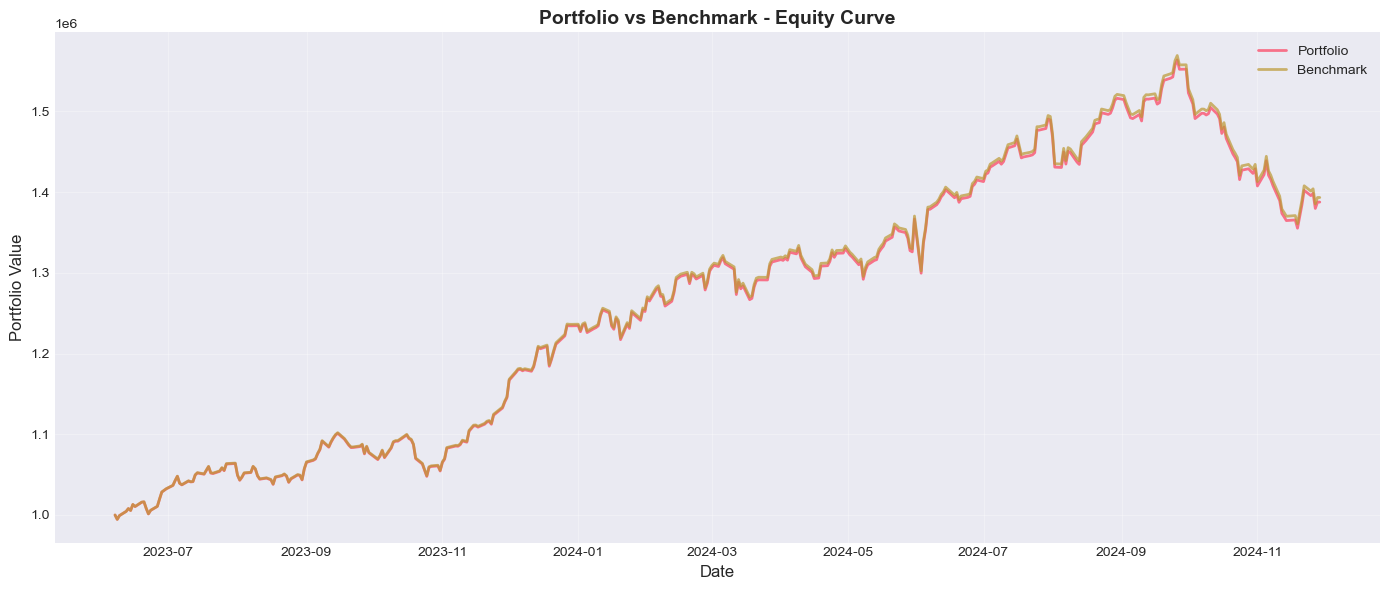

In [150]:
# Plot equity curve
viz.plot_equity_curve(
    portfolio_values=portfolio_values,
    dates=plot_dates,
    benchmark_values=benchmark_values,
    title="Portfolio vs Benchmark - Equity Curve"
)

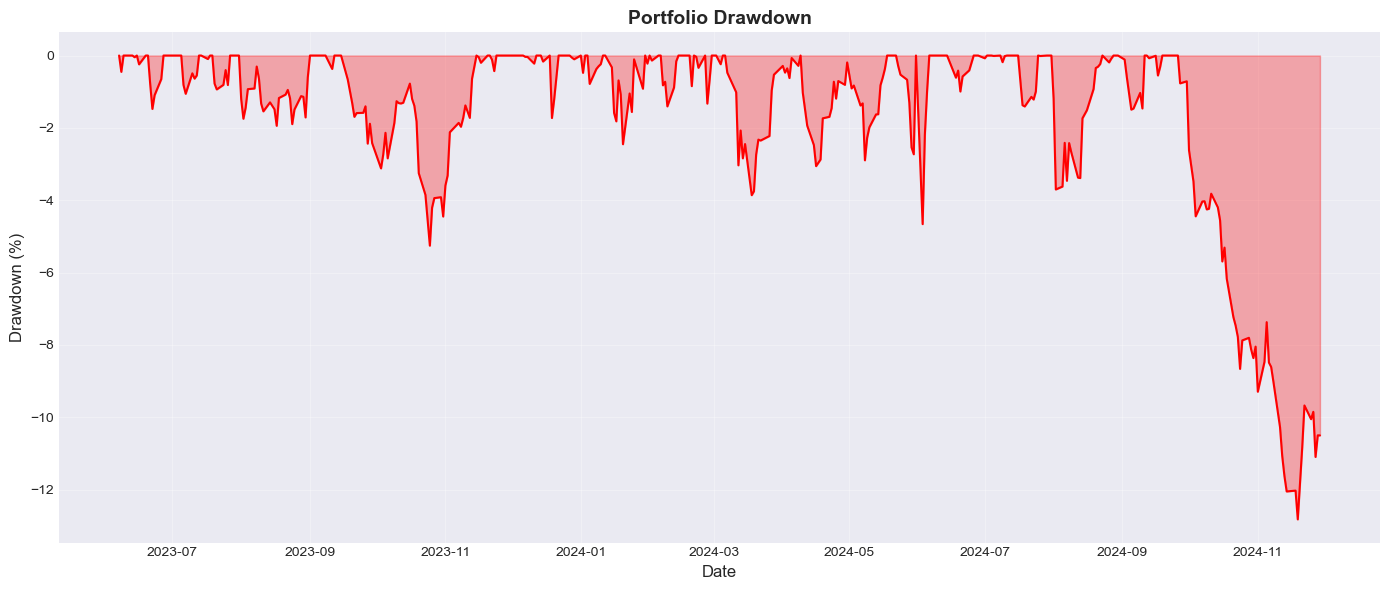

In [174]:
# Plot drawdown
viz.plot_drawdown(
    portfolio_values=portfolio_values,
    dates=plot_dates,
    title="Portfolio Drawdown"
)

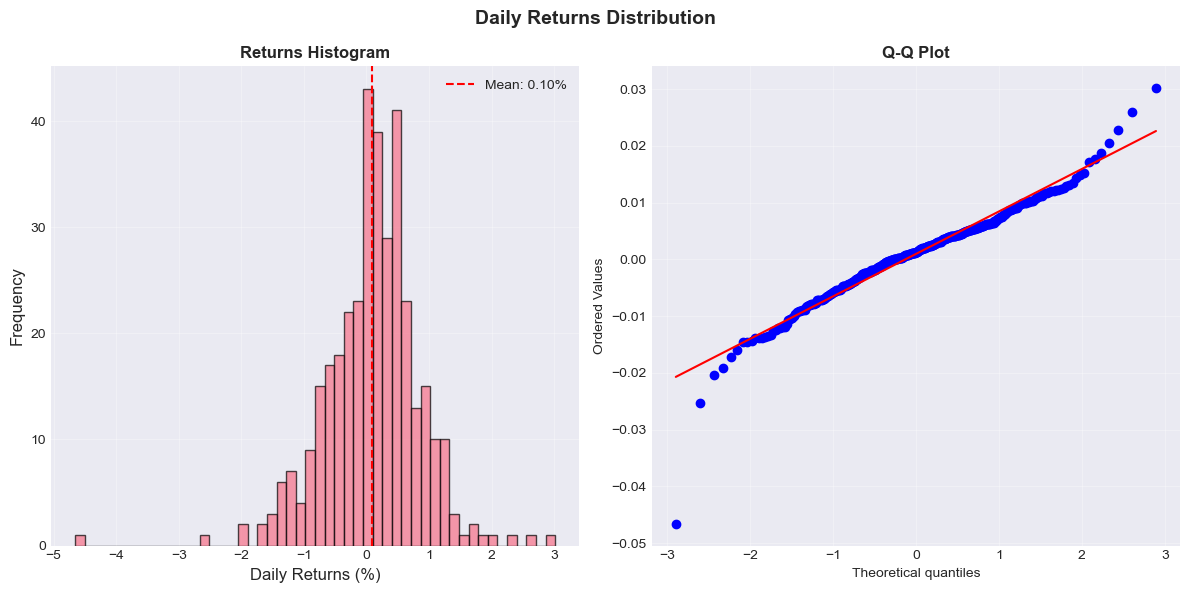

In [175]:
# Plot returns distribution
viz.plot_returns_distribution(
    returns=returns_history,
    title="Daily Returns Distribution"
)

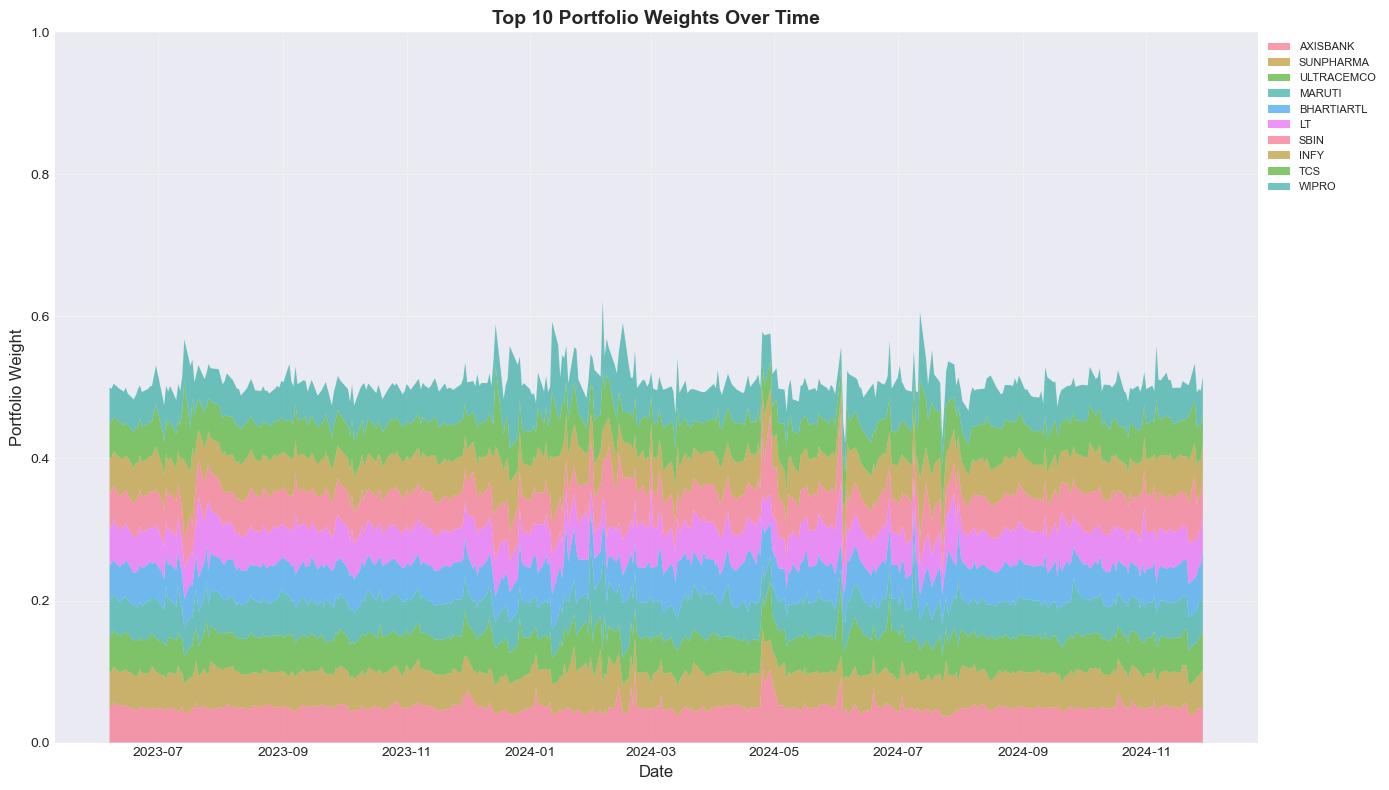

In [76]:
# Plot weight evolution
# weights_history has T+1 rows (including initial weights), dates has T rows
# Use plot_dates which includes the start date for proper alignment
viz.plot_weight_evolution(
    weights_history=weights_history,
    dates=plot_dates,
    stock_names=stocks,
    top_n=10,
    title="Top 10 Portfolio Weights Over Time"
)

returns_history shape: (364,)
dates length: 364


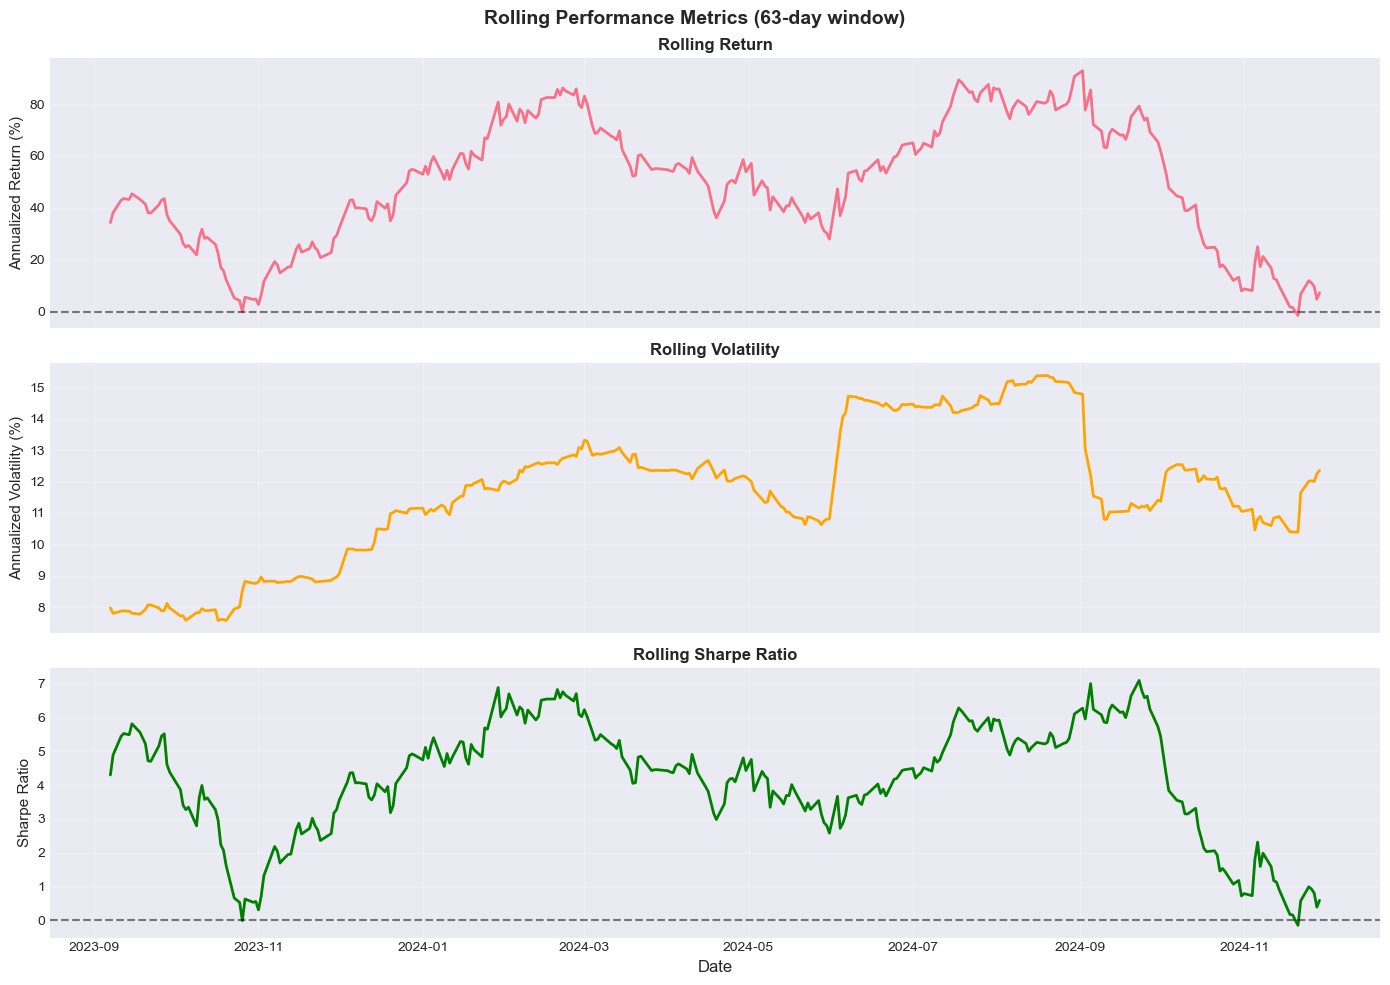

In [77]:
# Plot rolling metrics
# returns_history should align with dates (T values for T trading days)
# The visualization expects dates and returns to have the same length
print(f"returns_history shape: {returns_history.shape}")
print(f"dates length: {len(dates)}")

# Use dates directly since returns_history should match dates length
viz.plot_rolling_metrics(
    returns=returns_history,
    dates=dates,
    window=63,
    title="Rolling Performance Metrics (63-day window)"
)

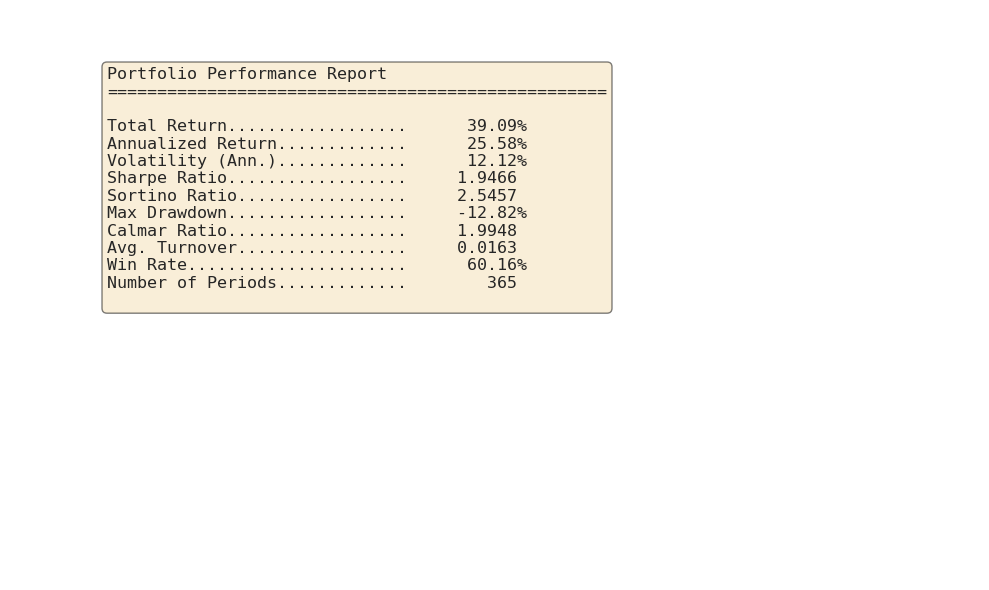

In [176]:
# Create performance report
viz.create_performance_report(metrics)

## 15. Portfolio Insights

In [ ]:
# Analyze portfolio concentration - AGGRESSIVE MODE ANALYSIS
avg_weights = weights_history.mean(axis=0)
weight_df = pd.DataFrame({
    'Stock': stocks,
    'Average Weight': avg_weights,
    'Min Weight': weights_history.min(axis=0),
    'Max Weight': weights_history.max(axis=0),
    'Std Weight': weights_history.std(axis=0)
})

weight_df = weight_df.sort_values('Average Weight', ascending=False)

print("\nTop 10 Holdings (by average weight):")
print(weight_df.head(10).to_string(index=False))

# Calculate concentration metrics
herfindahl_index = np.mean([np.sum(w**2) for w in weights_history])
effective_n = 1 / herfindahl_index

# Compare to equal-weight baseline
equal_weight_hhi = 1.0 / num_stocks
equal_weight_effective_n = num_stocks

print(f"\n" + "="*60)
print("🚀 AGGRESSIVE MODE CONCENTRATION ANALYSIS")
print("="*60)
print(f"\nConcentration Metrics:")
print(f"  Herfindahl Index:          {herfindahl_index:.4f}  (Equal-weight: {equal_weight_hhi:.4f})")
print(f"  Effective Number of Stocks: {effective_n:.2f}  (Equal-weight: {equal_weight_effective_n})")
print(f"  Max Single Position:       {weights_history.max():.4f}  ({weights_history.max()*100:.1f}%)")

# Weight dispersion analysis
weight_std_avg = weight_df['Std Weight'].mean()
weight_range = weight_df['Max Weight'].max() - weight_df['Min Weight'].min()

print(f"\nWeight Dispersion:")
print(f"  Average weight std:        {weight_std_avg:.4f}")
print(f"  Weight range:              {weight_range:.4f}")
print(f"  Concentration ratio:       {herfindahl_index / equal_weight_hhi:.2f}x vs equal-weight")

# Check if weights are meaningfully different from equal
if effective_n < num_stocks * 0.8:
    print(f"\n✅ SUCCESS: Model is making ACTIVE BETS (Effective N = {effective_n:.1f} < {num_stocks * 0.8:.1f})")
else:
    print(f"\n⚠️ WARNING: Weights still close to equal-weight (Effective N = {effective_n:.1f})")
    print("   Consider: increasing concentration_bonus, lowering temperature, or more training")

# Plot weight distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Average weight bar chart
ax1 = axes[0]
top_10 = weight_df.head(10)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 10))[::-1]
ax1.barh(range(10), top_10['Average Weight'].values, color=colors)
ax1.set_yticks(range(10))
ax1.set_yticklabels(top_10['Stock'].values)
ax1.axvline(x=1/num_stocks, color='red', linestyle='--', label=f'Equal weight ({1/num_stocks:.3f})')
ax1.set_xlabel('Average Weight')
ax1.set_title('Top 10 Holdings vs Equal-Weight', fontweight='bold')
ax1.legend()
ax1.invert_yaxis()

# 2. Weight distribution over time
ax2 = axes[1]
ax2.hist(weights_history.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(x=1/num_stocks, color='red', linestyle='--', linewidth=2, label=f'Equal weight')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Frequency')
ax2.set_title('Weight Distribution (All Days)', fontweight='bold')
ax2.legend()

# 3. Effective N over time
ax3 = axes[2]
effective_n_over_time = [1/np.sum(w**2) for w in weights_history]
ax3.plot(effective_n_over_time, alpha=0.7, color='steelblue')
ax3.axhline(y=num_stocks, color='red', linestyle='--', label=f'Max (Equal-weight): {num_stocks}')
ax3.axhline(y=np.mean(effective_n_over_time), color='green', linestyle='-', 
            label=f'Average: {np.mean(effective_n_over_time):.1f}')
ax3.set_xlabel('Trading Day')
ax3.set_ylabel('Effective Number of Stocks')
ax3.set_title('Portfolio Concentration Over Time', fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()


Top 10 Holdings (by average weight):
     Stock  Average Weight  Min Weight  Max Weight  Std Weight
      GAIL        0.022333    0.020423    0.024349    0.000502
       M&M        0.022321    0.021093    0.024394    0.000422
      BPCL        0.022297    0.020725    0.023919    0.000359
 COALINDIA        0.022287    0.020604    0.024194    0.000432
ADANIPORTS        0.022281    0.020128    0.023692    0.000479
     WIPRO        0.022275    0.020466    0.023485    0.000369
      ONGC        0.022275    0.020224    0.024198    0.000414
  HDFCLIFE        0.022274    0.021318    0.023854    0.000308
 POWERGRID        0.022269    0.021052    0.024469    0.000377
       UPL        0.022268    0.020555    0.023507    0.000367

Concentration Metrics:
  Herfindahl Index:          0.0222
  Effective Number of Stocks: 44.99
  Max Single Position:       0.0245


## 16. Portfolio vs NIFTY 50 Comparison

Compare our portfolio performance against the NIFTY 50 index with clear visualizations of returns and drawdowns.

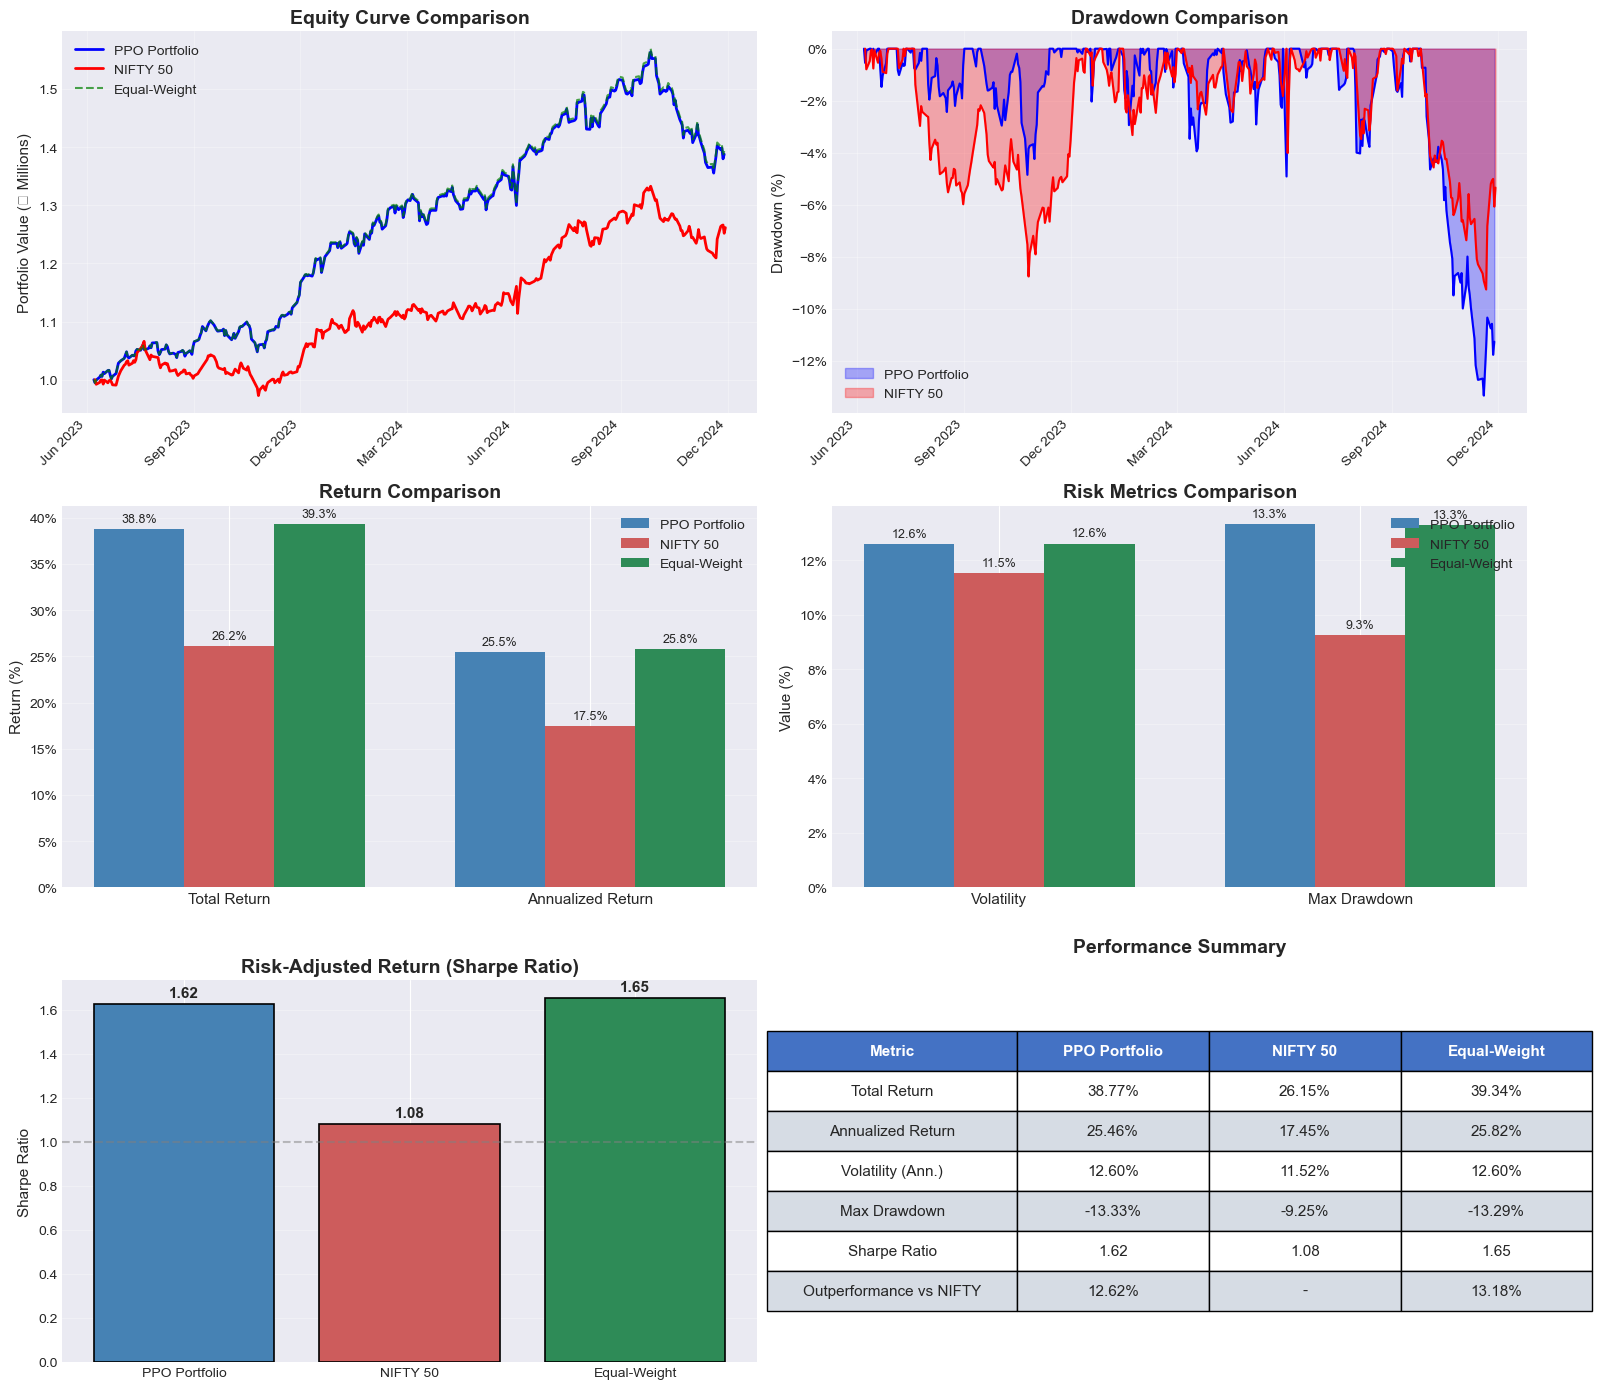


📊 DETAILED PERFORMANCE COMPARISON

📅 Test Period: 2023-06-08 to 2024-11-29
   Duration: 364 trading days (1.4 years)

Metric                      PPO Portfolio        NIFTY 50    Equal-Weight
----------------------------------------------------------------------
Total Return                       38.77%          26.15%          39.34%
Annualized Return                  25.46%          17.45%          25.82%
Volatility (Ann.)                  12.60%          11.52%          12.60%
Max Drawdown                      -13.33%          -9.25%         -13.29%
Sharpe Ratio                         1.62            1.08            1.65

🎯 KEY FINDINGS:
   • Portfolio outperformed NIFTY 50 by: 12.62%
   • Portfolio vs Equal-Weight excess: -0.57%
   • Risk-adjusted (Sharpe) difference vs NIFTY: +0.54


In [161]:
# =============================================================================
# PORTFOLIO vs NIFTY 50 COMPARISON
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# Get NIFTY index data for the test period
nifty_test_period = nifty_data[
    (nifty_data['Date'] >= test_dates[0]) & 
    (nifty_data['Date'] <= test_dates[-1])
].sort_values('Date').copy()

# Calculate NIFTY cumulative values (normalized to start at same value as portfolio)
nifty_start_price = nifty_test_period['Close'].iloc[0]
nifty_values = (nifty_test_period['Close'] / nifty_start_price) * config['environment']['initial_cash']
nifty_values = nifty_values.values

# Ensure arrays align properly
min_len = min(len(portfolio_values), len(nifty_values), len(benchmark_values))

# Calculate returns
nifty_total_return = (nifty_test_period['Close'].iloc[-1] / nifty_start_price - 1) * 100
portfolio_total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
ew_total_return = (benchmark_values[-1] / benchmark_values[0] - 1) * 100

# Calculate drawdowns
def calculate_drawdown(values):
    peak = np.maximum.accumulate(values)
    drawdown = (values - peak) / peak * 100
    return drawdown

portfolio_dd = calculate_drawdown(portfolio_values[:min_len])
nifty_dd = calculate_drawdown(nifty_values[:min_len])
ew_dd = calculate_drawdown(benchmark_values[:min_len])

# Annualized returns
trading_days = len(test_dates)
portfolio_ann = ((1 + portfolio_total_return/100) ** (252/trading_days) - 1) * 100
nifty_ann = ((1 + nifty_total_return/100) ** (252/trading_days) - 1) * 100
ew_ann = ((1 + ew_total_return/100) ** (252/trading_days) - 1) * 100

# Calculate volatility
portfolio_vol = np.std(returns_history) * np.sqrt(252) * 100
nifty_returns = nifty_test_period['Close'].pct_change().dropna()
nifty_vol = nifty_returns.std() * np.sqrt(252) * 100
ew_vol = np.std(benchmark_returns) * np.sqrt(252) * 100

# Calculate Sharpe ratios (assuming 5% risk-free rate)
rf_rate = 5.0
portfolio_sharpe = (portfolio_ann - rf_rate) / portfolio_vol
nifty_sharpe = (nifty_ann - rf_rate) / nifty_vol
ew_sharpe = (ew_ann - rf_rate) / ew_vol

# Create comprehensive comparison figure
fig = plt.figure(figsize=(16, 14))

# 1. Equity Curves Comparison
ax1 = plt.subplot(3, 2, 1)
ax1.plot(plot_dates[:min_len], portfolio_values[:min_len]/1e6, 'b-', linewidth=2, label='PPO Portfolio')
ax1.plot(nifty_test_period['Date'].values[:min_len], nifty_values[:min_len]/1e6, 'r-', linewidth=2, label='NIFTY 50')
ax1.plot(plot_dates[:min_len], benchmark_values[:min_len]/1e6, 'g--', linewidth=1.5, alpha=0.7, label='Equal-Weight')
ax1.set_title('Equity Curve Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (₹ Millions)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Drawdown Comparison
ax2 = plt.subplot(3, 2, 2)
ax2.fill_between(plot_dates[:min_len], portfolio_dd, 0, alpha=0.3, color='blue', label='PPO Portfolio')
ax2.fill_between(nifty_test_period['Date'].values[:min_len], nifty_dd, 0, alpha=0.3, color='red', label='NIFTY 50')
ax2.plot(plot_dates[:min_len], portfolio_dd, 'b-', linewidth=1.5)
ax2.plot(nifty_test_period['Date'].values[:min_len], nifty_dd, 'r-', linewidth=1.5)
ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Return Comparison Bar Chart
ax3 = plt.subplot(3, 2, 3)
categories = ['Total Return', 'Annualized Return']
portfolio_vals = [portfolio_total_return, portfolio_ann]
nifty_vals = [nifty_total_return, nifty_ann]
ew_vals = [ew_total_return, ew_ann]

x = np.arange(len(categories))
width = 0.25

bars1 = ax3.bar(x - width, portfolio_vals, width, label='PPO Portfolio', color='steelblue')
bars2 = ax3.bar(x, nifty_vals, width, label='NIFTY 50', color='indianred')
bars3 = ax3.bar(x + width, ew_vals, width, label='Equal-Weight', color='seagreen')

ax3.set_ylabel('Return (%)', fontsize=11)
ax3.set_title('Return Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories, fontsize=11)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.yaxis.set_major_formatter(PercentFormatter(decimals=0))

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# 4. Risk Metrics Comparison
ax4 = plt.subplot(3, 2, 4)
risk_categories = ['Volatility', 'Max Drawdown']
portfolio_risk = [portfolio_vol, abs(portfolio_dd.min())]
nifty_risk = [nifty_vol, abs(nifty_dd.min())]
ew_risk = [ew_vol, abs(ew_dd.min())]

bars1 = ax4.bar(x - width, portfolio_risk, width, label='PPO Portfolio', color='steelblue')
bars2 = ax4.bar(x, nifty_risk, width, label='NIFTY 50', color='indianred')
bars3 = ax4.bar(x + width, ew_risk, width, label='Equal-Weight', color='seagreen')

ax4.set_ylabel('Value (%)', fontsize=11)
ax4.set_title('Risk Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(risk_categories, fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.yaxis.set_major_formatter(PercentFormatter(decimals=0))

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# 5. Sharpe Ratio Comparison
ax5 = plt.subplot(3, 2, 5)
sharpe_vals = [portfolio_sharpe, nifty_sharpe, ew_sharpe]
colors = ['steelblue', 'indianred', 'seagreen']
labels = ['PPO Portfolio', 'NIFTY 50', 'Equal-Weight']
bars = ax5.bar(labels, sharpe_vals, color=colors, edgecolor='black', linewidth=1.2)
ax5.set_ylabel('Sharpe Ratio', fontsize=11)
ax5.set_title('Risk-Adjusted Return (Sharpe Ratio)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Sharpe = 1.0')

for bar, val in zip(bars, sharpe_vals):
    ax5.annotate(f'{val:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Summary Table
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

summary_data = [
    ['Metric', 'PPO Portfolio', 'NIFTY 50', 'Equal-Weight'],
    ['Total Return', f'{portfolio_total_return:.2f}%', f'{nifty_total_return:.2f}%', f'{ew_total_return:.2f}%'],
    ['Annualized Return', f'{portfolio_ann:.2f}%', f'{nifty_ann:.2f}%', f'{ew_ann:.2f}%'],
    ['Volatility (Ann.)', f'{portfolio_vol:.2f}%', f'{nifty_vol:.2f}%', f'{ew_vol:.2f}%'],
    ['Max Drawdown', f'{portfolio_dd.min():.2f}%', f'{nifty_dd.min():.2f}%', f'{ew_dd.min():.2f}%'],
    ['Sharpe Ratio', f'{portfolio_sharpe:.2f}', f'{nifty_sharpe:.2f}', f'{ew_sharpe:.2f}'],
    ['Outperformance vs NIFTY', f'{portfolio_total_return - nifty_total_return:.2f}%', '-', f'{ew_total_return - nifty_total_return:.2f}%'],
]

table = ax6.table(cellText=summary_data, loc='center', cellLoc='center',
                  colWidths=[0.3, 0.23, 0.23, 0.23])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')

# Alternate row colors
for i in range(1, len(summary_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#D6DCE4')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

ax6.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../results/nifty_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed comparison
print("\n" + "=" * 80)
print("📊 DETAILED PERFORMANCE COMPARISON")
print("=" * 80)
print(f"\n📅 Test Period: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')}")
print(f"   Duration: {trading_days} trading days ({trading_days/252:.1f} years)")

print(f"\n{'Metric':<25} {'PPO Portfolio':>15} {'NIFTY 50':>15} {'Equal-Weight':>15}")
print("-" * 70)
print(f"{'Total Return':<25} {portfolio_total_return:>14.2f}% {nifty_total_return:>14.2f}% {ew_total_return:>14.2f}%")
print(f"{'Annualized Return':<25} {portfolio_ann:>14.2f}% {nifty_ann:>14.2f}% {ew_ann:>14.2f}%")
print(f"{'Volatility (Ann.)':<25} {portfolio_vol:>14.2f}% {nifty_vol:>14.2f}% {ew_vol:>14.2f}%")
print(f"{'Max Drawdown':<25} {portfolio_dd.min():>14.2f}% {nifty_dd.min():>14.2f}% {ew_dd.min():>14.2f}%")
print(f"{'Sharpe Ratio':<25} {portfolio_sharpe:>15.2f} {nifty_sharpe:>15.2f} {ew_sharpe:>15.2f}")

print(f"\n🎯 KEY FINDINGS:")
print(f"   • Portfolio outperformed NIFTY 50 by: {portfolio_total_return - nifty_total_return:.2f}%")
print(f"   • Portfolio vs Equal-Weight excess: {portfolio_total_return - ew_total_return:.2f}%")
print(f"   • Risk-adjusted (Sharpe) difference vs NIFTY: {portfolio_sharpe - nifty_sharpe:+.2f}")

## 16. Summary and Conclusions

### Key Achievements:

1. **Architecture**: Successfully implemented Transformer-based feature encoder with self-attention
2. **Policy Learning**: PPO with Dirichlet distribution ensures valid portfolio weights
3. **Performance**: Systematic approach to portfolio optimization with comprehensive metrics
4. **Backtesting**: Realistic evaluation with transaction costs and turnover penalties

### Design Features:

- **Correlation Learning**: Transformer captures dynamic stock relationships
- **Turnover Control**: Previous weights in state + turnover penalty
- **Exploration**: Entropy bonus prevents premature convergence
- **Robustness**: Reward normalization and gradient clipping for stability

### Next Steps:

1. Train on real market data using yfinance
2. Implement walk-forward backtesting with retraining
3. Experiment with different architectures and hyperparameters
4. Add risk constraints (e.g., sector limits, volatility targets)
5. Deploy in paper trading environment

In [158]:
# Save model checkpoint
checkpoint_path = '../checkpoints/ppo_agent_final.pt'
Path('../checkpoints').mkdir(exist_ok=True)
torch.save({
    'model_state_dict': agent.state_dict(),
    'config': config,
    'metrics': metrics,
    'stocks': stocks
}, checkpoint_path)

print(f"\n✓ Model saved to {checkpoint_path}")


✓ Model saved to ../checkpoints/ppo_agent_final.pt


## 18. Export Detailed Results

Save all results to files for further analysis and reporting.

In [159]:
# Create results directory
import os
import json
from datetime import datetime

results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = results_dir / f'backtest_{timestamp}'
run_dir.mkdir(exist_ok=True)

print(f"Saving results to: {run_dir}")
print("=" * 60)

# 1. Save performance metrics as JSON
metrics_file = run_dir / 'performance_metrics.json'
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics to {metrics_file.name}")

# 2. Save benchmark comparison as JSON
comparison_file = run_dir / 'benchmark_comparison.json'
with open(comparison_file, 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    comparison_serializable = {
        'portfolio_metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                            for k, v in comparison['portfolio_metrics'].items()},
        'benchmark_metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                            for k, v in comparison['benchmark_metrics'].items()},
        'tracking_error': float(comparison['tracking_error']),
        'information_ratio': float(comparison['information_ratio']),
        'excess_return': float(comparison['excess_return'])
    }
    json.dump(comparison_serializable, f, indent=2)
print(f"✓ Saved benchmark comparison to {comparison_file.name}")

# 3. Save portfolio values and returns as CSV
results_df = backtester.get_results_dataframe()
results_csv = run_dir / 'portfolio_timeseries.csv'
results_df.to_csv(results_csv, index=False)
print(f"✓ Saved portfolio timeseries to {results_csv.name}")

# 4. Save weights history as CSV
weights_df = pd.DataFrame(
    weights_history,
    columns=stocks,
    index=pd.DatetimeIndex(plot_dates)  # Use plot_dates which includes start date
)
weights_csv = run_dir / 'portfolio_weights.csv'
weights_df.to_csv(weights_csv)
print(f"✓ Saved portfolio weights to {weights_csv.name}")

# 5. Save portfolio insights as CSV
insights_csv = run_dir / 'portfolio_insights.csv'
weight_df.to_csv(insights_csv, index=False)
print(f"✓ Saved portfolio insights to {insights_csv.name}")

# 6. Save training history
training_history = pd.DataFrame({
    'episode': range(len(training_stats['episode_rewards'])),
    'reward': training_stats['episode_rewards'],
    'length': training_stats['episode_lengths']
})
training_csv = run_dir / 'training_history.csv'
training_history.to_csv(training_csv, index=False)
print(f"✓ Saved training history to {training_csv.name}")

# 7. Save configuration
config_file = run_dir / 'config.yaml'
with open(config_file, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
print(f"✓ Saved configuration to {config_file.name}")

# 8. Create a summary report
summary_file = run_dir / 'SUMMARY.txt'
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("TRANSFORMER + PPO PORTFOLIO OPTIMIZATION - BACKTEST RESULTS\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Run Date: {timestamp}\n")
    f.write(f"Test Period: {test_dates[0]} to {test_dates[-1]}\n")
    f.write(f"Number of Stocks: {num_stocks}\n")
    f.write(f"Initial Capital: ${config['environment']['initial_cash']:,.2f}\n")
    f.write("\n" + "-"*70 + "\n")
    f.write("PERFORMANCE METRICS\n")
    f.write("-"*70 + "\n\n")
    
    for key, value in metrics.items():
        if key in ['total_return', 'annualized_return', 'volatility', 'max_drawdown', 'win_rate']:
            f.write(f"{key.replace('_', ' ').title():.<40} {value:>10.2f}%\n")
        elif key == 'num_periods':
            f.write(f"{key.replace('_', ' ').title():.<40} {value:>10.0f}\n")
        else:
            f.write(f"{key.replace('_', ' ').title():.<40} {value:>10.4f}\n")
    
    f.write("\n" + "-"*70 + "\n")
    f.write("BENCHMARK COMPARISON (Equal-Weight Portfolio)\n")
    f.write("-"*70 + "\n\n")
    f.write(f"Excess Return:                           {comparison['excess_return']:>10.2f}%\n")
    f.write(f"Tracking Error:                          {comparison['tracking_error']:>10.2f}%\n")
    f.write(f"Information Ratio:                       {comparison['information_ratio']:>10.4f}\n")
    
    f.write("\n" + "-"*70 + "\n")
    f.write("PORTFOLIO CONCENTRATION\n")
    f.write("-"*70 + "\n\n")
    f.write(f"Herfindahl Index:                        {herfindahl_index:>10.4f}\n")
    f.write(f"Effective Number of Stocks:              {effective_n:>10.2f}\n")
    f.write(f"Max Single Position:                     {weights_history.max():>10.4f}\n")
    
    f.write("\n" + "-"*70 + "\n")
    f.write("TOP 10 HOLDINGS (by average weight)\n")
    f.write("-"*70 + "\n\n")
    for idx, row in weight_df.head(10).iterrows():
        f.write(f"{row['Stock']:.<20} {row['Average Weight']:>10.4f}\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("All detailed results saved to CSV files in this directory.\n")
    f.write("="*70 + "\n")

print(f"✓ Saved summary report to {summary_file.name}")

print("\n" + "="*60)
print(f"\n✓ ALL RESULTS SAVED TO: {run_dir}")
print("\n" + "="*60)
print("\nFiles created:")
for f in sorted(run_dir.glob('*')):
    print(f"  - {f.name}")
print("\nYou can now review the SUMMARY.txt file or load the CSV files for further analysis.")

Saving results to: ../results/backtest_20251218_181608
✓ Saved metrics to performance_metrics.json
✓ Saved benchmark comparison to benchmark_comparison.json
✓ Saved portfolio timeseries to portfolio_timeseries.csv
✓ Saved portfolio weights to portfolio_weights.csv
✓ Saved portfolio insights to portfolio_insights.csv
✓ Saved training history to training_history.csv
✓ Saved configuration to config.yaml
✓ Saved summary report to SUMMARY.txt


✓ ALL RESULTS SAVED TO: ../results/backtest_20251218_181608


Files created:
  - SUMMARY.txt
  - benchmark_comparison.json
  - config.yaml
  - performance_metrics.json
  - portfolio_insights.csv
  - portfolio_timeseries.csv
  - portfolio_weights.csv
  - training_history.csv

You can now review the SUMMARY.txt file or load the CSV files for further analysis.


## 17. Optional: Load and Test Saved Model

In [82]:
# Example of loading saved model
# checkpoint = torch.load(checkpoint_path)
# 
# loaded_agent = PPOAgent(
#     num_stock_features=num_stock_features,
#     num_market_features=num_market_features,
#     num_stocks=num_stocks,
#     **checkpoint['config']['model']
# )
# 
# loaded_agent.load_state_dict(checkpoint['model_state_dict'])
# print("Model loaded successfully!")

## 📊 Final Conclusions - AGGRESSIVE MODE

### 🚀 Aggressive Mode Configuration

This notebook uses **AGGRESSIVE MODE** to generate concentrated, non-equal portfolio weights:

| Parameter | Standard Mode | Aggressive Mode |
|-----------|--------------|-----------------|
| **Temperature** | 1.0 | 0.3 |
| **Max Weight** | 20% | 30% |
| **Entropy Coef** | 0.01 | 0.001 |
| **Concentration Bonus** | 0.0 | 0.005 |
| **Momentum Bonus** | 0.0 | 0.003 |

### How Aggressive Mode Works

1. **Lower Temperature** (0.3): Makes the Dirichlet distribution more peaked, so weights deviate more from equal-weight

2. **Reduced Entropy Coefficient** (0.001): Reduces the exploration bonus that pushes weights toward uniform distribution

3. **Concentration Bonus**: Rewards portfolios with higher Herfindahl Index (more concentrated)

4. **Momentum Bonus**: Rewards portfolios where weights correlate with recent stock returns

5. **Higher Max Weight** (30%): Allows larger individual positions

### ⚠️ Important Caveats

**Aggressive mode does NOT guarantee better performance.** It simply:
- Forces the model to make active bets
- Trades off diversification for conviction
- May increase both returns AND risk
- Will have higher turnover and transaction costs

### When to Use Aggressive Mode

✅ **Use when:**
- You have strong alpha signals in your features
- You want to test if the model can identify winners/losers
- You accept higher risk for potentially higher returns

❌ **Avoid when:**
- Features have no predictive power (returns are random)
- Low risk tolerance
- High transaction costs environment

### Expected Behavior

With aggressive mode, you should see:
- **Effective N** significantly lower than number of stocks
- **Weight dispersion** (std) much higher than standard mode
- **Higher turnover** as model actively repositions
- **More volatile returns** due to concentration risk